# MPC Surrogate Training Pipeline

This notebook implements the complete training and evaluation pipeline for approximating MPC policies using neural networks.

## Dataset Structure
- **States**: Joint positions and velocities (6D) - [q1, q2, q3, q̇1, q̇2, q̇3]
- **Targets**: End-effector target positions (3D) - [x, y, z]
- **Actions**: MPC torques (3D) - [τ1, τ2, τ3]

The goal is to learn a mapping: (state, target) → MPC torques

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

import json
import os
from tqdm import tqdm
import time
import copy
from torch.nn.utils.rnn import pad_sequence
import random

def compute_direction_accuracy(y_true, y_pred):
    """
    Sum the number of time the sign of the predicted torque matches the true torque.
    """
    return np.sum(np.sign(y_true) == np.sign(y_pred)) / (3 * len(y_true))

torch.manual_seed(42)
np.random.seed(42)

INPUT_DIR = "../data/"
OUTPUT_DIR = "../results/pytorch_comparison/"

DATA_PATH = os.path.join(INPUT_DIR, "robot_mpc_dataset.h5")
RESULTS_DIR = os.path.join(OUTPUT_DIR, "results")
MODELS_DIR = os.path.join(OUTPUT_DIR, "models")

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

def _select_device():
    """Prefer CUDA, then Intel GPU via XPU, else CPU."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    # Intel GPU via oneAPI / XPU
    if hasattr(torch, "xpu") and hasattr(torch.xpu, "is_available") and torch.xpu.is_available():
        return torch.device("xpu")
    return torch.device("cpu")

DEVICE = _select_device()
print(f"Using device: {DEVICE}")


Using device: xpu


## Data Preparation

In [2]:
class MPCDataset(Dataset):
    def __init__(self, filepath, episode_keys, mode="mlp", augment=False, window_size=1):
        """
        mode: 'mlp' (flattens trajectories) or 'rnn' (keeps trajectories intact)
        window_size: number of past steps of state history to include (MLP only).
        """
        super().__init__()
        self.augment = augment
        self.mode = mode
        self.window_size = max(1, int(window_size))
        self.data = []  # (inputs, actions) tuples

        with h5py.File(filepath, "r") as f:
            grp_eps = f["episodes"]
            for ep in episode_keys:
                s = torch.from_numpy(grp_eps[ep]["states"][:]).float()  # (T, 6)
                t = torch.from_numpy(grp_eps[ep]["targets"][:]).float()  # (T, 3)
                a = torch.from_numpy(grp_eps[ep]["actions"][:]).float()  # (T, 3)

                # states + targets as input -> (T, 9)
                inp = torch.cat([s, t], dim=-1)
                self.data.append((inp, a))

        if self.mode == "mlp":
            # Build sliding-window samples when window_size > 1
            inputs_list, actions_list = [], []
            if self.window_size == 1:
                inputs_list.append(torch.cat([x[0] for x in self.data], dim=0))
                actions_list.append(torch.cat([x[1] for x in self.data], dim=0))
                self.inputs = torch.cat(inputs_list, dim=0)
                self.actions = torch.cat(actions_list, dim=0)
            else:
                for inp, act in self.data:
                    states = inp[:, :6]
                    targets = inp[:, 6:]
                    T = states.shape[0]
                    if T < 1:
                        continue
                    # Start from i=0 and pad with ZEROS if needed
                    for i in range(T):
                        # Get window: states[max(0, i-window_size+1):i+1]
                        start_idx = max(0, i - self.window_size + 1)
                        window_states = states[start_idx:i + 1]  # shape: (variable_len, 6)
                        
                        # Pad with ZEROS if window is incomplete (early in episode)
                        if window_states.shape[0] < self.window_size:
                            padding_size = self.window_size - window_states.shape[0]
                            padding = torch.zeros(padding_size, 6)  # Zero padding
                            window_states = torch.cat([padding, window_states], dim=0)
                        
                        window_states_flat = window_states.reshape(-1)  # (window_size*6)
                        target_now = targets[i]  # (3)
                        x = torch.cat([window_states_flat, target_now], dim=0)  # (window_size*6 + 3)
                        inputs_list.append(x)
                        actions_list.append(act[i])
                
                self.inputs = torch.stack(inputs_list) if inputs_list else torch.empty(0, self.window_size * 6 + 3)
                self.actions = torch.stack(actions_list) if actions_list else torch.empty(0, 3)

    def __len__(self):
        return len(self.inputs) if self.mode == "mlp" else len(self.data)

    def __getitem__(self, idx):
        if self.mode == "mlp":
            x, y = self.inputs[idx], self.actions[idx]
            if self.augment:
                noise_state = torch.randn(min(len(x) - 3, self.window_size * 6)) * 0.01
                x[:self.window_size * 6] += noise_state
                y = y + torch.randn_like(y) * 0.005
            return x, y
        else:
            x, y = self.data[idx]  # (T, 9), (T, 3)
            if self.augment:
                noise_x = torch.randn_like(x)
                noise_x[:, 6:] = 0  # no noise on targets
                x = x + (noise_x * 0.01)
                y = y + (torch.randn_like(y) * 0.005)
            return x, y


def collate_rnn(batch):
    inputs, actions = zip(*batch)
    lengths = torch.tensor([x.size(0) for x in inputs])

    # pad variable lengths (T0, T1...) to max length in batch
    padded_inputs = pad_sequence(inputs, batch_first=True)  # (B, T_max, 9)
    padded_actions = pad_sequence(actions, batch_first=True)  # (B, T_max, 3)

    return padded_inputs, padded_actions, lengths

def create_dataloaders(filepath, train_ratio=0.8, val_ratio=0.1, batch_size=32, dataset_type="mlp", window_size=1):
    """
    Creates Train (80%), Validation (10%), and Test (10%) dataloaders.
    window_size applies only to MLP mode.
    """
    with h5py.File(filepath, "r") as f:
        keys = np.array(sorted(f["episodes"].keys()))
        if dataset_type == "mlp" and window_size == 1:
          # we figured out during scaling experiment only 50% of the dataset is sufficient
          # only truncate for MLP with window_size 1
          truncated_len = int(len(keys) * 0.5)
          keys = keys[:truncated_len]

    np.random.shuffle(keys)

    n_total = len(keys)
    train_end = int(n_total * train_ratio)
    val_end = int(n_total * (train_ratio + val_ratio))

    train_keys = keys[:train_end]
    val_keys = keys[train_end:val_end]
    test_keys = keys[val_end:]  # remainder (approx 10%)

    if dataset_type == "mlp":
        train_ds = MPCDataset(filepath, train_keys, mode="mlp", augment=True, window_size=window_size)
        val_ds = MPCDataset(filepath, val_keys, mode="mlp", augment=False, window_size=window_size)
        test_ds = MPCDataset(filepath, test_keys, mode="mlp", augment=False, window_size=window_size)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    elif dataset_type == "rnn":
        train_ds = MPCDataset(filepath, train_keys, mode="rnn", augment=True)
        val_ds = MPCDataset(filepath, val_keys, mode="rnn", augment=False)
        test_ds = MPCDataset(filepath, test_keys, mode="rnn", augment=False)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_rnn, drop_last=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_rnn)
        test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_rnn)
    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")

    print(f"Split sizes: Train={len(train_keys)}, Val={len(val_keys)}, Test={len(test_keys)} | window_size={window_size}")

    return train_dl, val_dl, test_dl

# Data vizualization

Visualizing episode 632


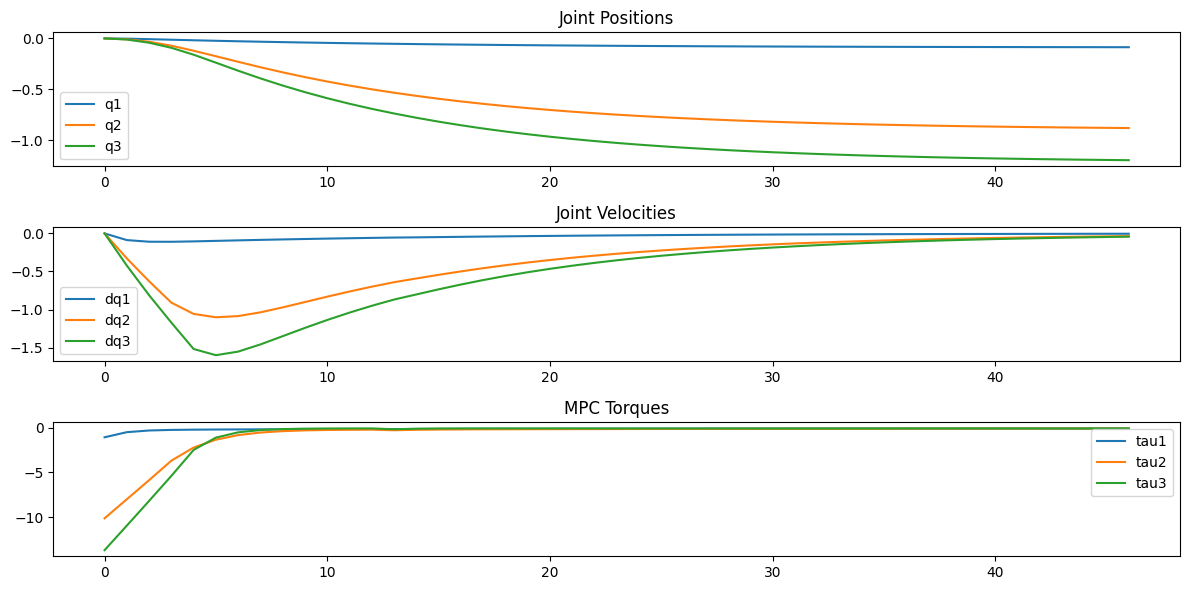

In [3]:
episodes = []
with h5py.File(DATA_PATH, "r") as f:
    keys = np.array(sorted(f["episodes"].keys()))
    for ep in keys:
        grp = f["episodes"][ep]
        states = grp["states"][:]
        targets = grp["targets"][:]
        actions = grp["actions"][:]
        episodes.append((states, targets, actions))

# pick a random episode
ep_idx = random.randint(0, len(episodes) - 1)
episode = episodes[ep_idx]
ep_states = episode[0]
ep_targets = episode[1]
ep_actions = episode[2]

print(f"Visualizing episode {ep_idx}")

# joint positions
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(ep_states[:, 0], label="q1")
plt.plot(ep_states[:, 1], label="q2")
plt.plot(ep_states[:, 2], label="q3")
plt.title("Joint Positions")
plt.legend()

# joint velocities
plt.subplot(3, 1, 2)
plt.plot(ep_states[:, 3], label="dq1")
plt.plot(ep_states[:, 4], label="dq2")
plt.plot(ep_states[:, 5], label="dq3")
plt.title("Joint Velocities")
plt.legend()

# MPC actions
plt.subplot(3, 1, 3)
plt.plot(ep_actions[:, 0], label="tau1")
plt.plot(ep_actions[:, 1], label="tau2")
plt.plot(ep_actions[:, 2], label="tau3")
plt.title("MPC Torques")
plt.legend()

plt.tight_layout()
plt.show()


## Model Architectures

In [4]:
class MLP(nn.Module):
    """Simple Multi-Layer Perceptron"""
    def __init__(self, input_dim=9, hidden_dims=[128, 64], output_dim=3):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class GRU(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, num_layers=2, output_dim=3):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths=None):
        # x: (B, T, 9)
        if lengths is not None:
            lengths_cpu = lengths.cpu()
            x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths_cpu, batch_first=True, enforce_sorted=False)
            out_packed, hn = self.gru(x_packed)
            out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        else:
            out, hn = self.gru(x) # (B, T_max, 3)

        out = self.fc(out)
        return out

## Training and Evaluation Functions

In [5]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    num_batches = 0

    for batch in train_loader:
        if len(batch) == 3: # RNN
            inputs, targets, lengths = batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs, lengths)

            # Masking
            mask = torch.arange(targets.size(1), device=DEVICE)[None, :] < lengths[:, None].to(DEVICE)
            mask = mask.unsqueeze(-1).expand_as(targets)

            loss_raw = criterion(outputs, targets)
            loss = (loss_raw * mask).sum() / mask.sum()

        else: # MLP
            inputs, targets = batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)

            loss_raw = criterion(outputs, targets)
            loss = loss_raw.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

def evaluate(model, test_loader, criterion):
    """Evaluate model on test set"""
    model.eval()
    total_loss = 0
    num_batches = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            if len(batch) == 3: #RNN
                inputs, targets, lengths = batch
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs, lengths)

                # Masking
                mask = torch.arange(targets.size(1), device=DEVICE)[None, :] < lengths[:, None].to(DEVICE)
                mask = mask.unsqueeze(-1).expand_as(targets)

                loss_raw = criterion(outputs, targets)
                loss = (loss_raw * mask).sum() / mask.sum()

                # Filter predictions and targets for metrics
                # We flatten and remove padded values
                outputs_masked = outputs[mask].view(-1, 3)
                targets_masked = targets[mask].view(-1, 3)

                all_predictions.append(outputs_masked.cpu().numpy())
                all_targets.append(targets_masked.cpu().numpy())

            else:
                inputs, targets = batch
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss_raw = criterion(outputs, targets)
                loss = loss_raw.mean()

                all_predictions.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())

            total_loss += loss.item()
            num_batches += 1

    predictions = np.concatenate(all_predictions)
    targets = np.concatenate(all_targets)

    if predictions.ndim == 3:
        predictions = predictions.reshape(-1, predictions.shape[-1])
        targets = targets.reshape(-1, targets.shape[-1])

    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    da = compute_direction_accuracy(targets, predictions)
    ev = explained_variance_score(targets, predictions)
    mse_per_torque = mean_squared_error(targets, predictions, multioutput="raw_values")

    return {
        'loss': total_loss / num_batches,
        'mse': mse,
        'mae': mae,
        'direction_accuracy': da,
        'explained_variance': ev,
        'predictions': predictions,
        'targets': targets,
        'mse_per_torque': mse_per_torque
    }

In [6]:
def train_model(model_name, model, train_loader, test_loader, validation_loader,
                loss_type="mse", num_epochs=50, trial=0):
    if loss_type == "mse":
        criterion = nn.MSELoss(reduction='none')
    elif loss_type == "mae":
        criterion = nn.L1Loss(reduction='none')
    else:
        raise ValueError("loss_type must be 'mse' or 'mae'")

    # keep track of both for reporting, but only optimize 'criterion'
    monitor_mse = nn.MSELoss(reduction='none')
    monitor_mae = nn.L1Loss(reduction='none')

    optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    results = {
        'model_name': model_name,
        'loss_type': loss_type,
        'training_history': [],
        'best_results': None,
    }

    best_val_loss = float('inf')
    pbar = tqdm(range(num_epochs), desc=f"Training {model_name}")

    try:
        for epoch in pbar:
            start_time = time.time()

            train_loss = train_epoch(model, train_loader, criterion, optimizer)
            val_metrics = evaluate(model, validation_loader, criterion)

            epoch_time = time.time() - start_time

            pbar.set_postfix({
                "loss": f"{val_metrics['loss']:.4f}",
                "mse": f"{val_metrics['mse']:.4f}",
                "mae": f"{val_metrics['mae']:.4f}"
            })

            results['training_history'].append({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'val_loss': val_metrics['loss'],
                'val_mse': val_metrics['mse'],
                'val_mae': val_metrics['mae'],
                'val_da': val_metrics['direction_accuracy'],
                'val_ev': val_metrics['explained_variance'],
                'val_mse_per_torque': val_metrics['mse_per_torque'],
                'epoch_time': epoch_time
            })

            # save best model based on the chosen loss_type
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                results['best_results'] = val_metrics.copy()
                results['best_results'].pop('predictions', None)
                results['best_results'].pop('targets', None)
                model_output_path = os.path.join(MODELS_DIR, f'{model_name}_best_{loss_type}_{trial}.pt')
                torch.save(model, model_output_path)

    except KeyboardInterrupt:
        print("\nInterrupted.")
    finally:
        # save the results of the best model on the test set
        best_model_path = os.path.join(MODELS_DIR, f'{model_name}_best_{loss_type}_{trial}.pt')
        if os.path.exists(best_model_path):
            model = torch.load(best_model_path, weights_only=False)
            final_test_metrics = evaluate(model, test_loader, criterion)

            final_test_metrics.pop('predictions', None)
            final_test_metrics.pop('targets', None)
            results['final_test_results'] = final_test_metrics

            print(f"Final Test MSE: {final_test_metrics['mse']:.5f}")
        else:
            print("failed opening best model")

        json_str = json.dumps(results, indent=2, default=lambda x: float(x) if isinstance(x, (np.floating, torch.Tensor)) else str(x))
        results_output_path = os.path.join(RESULTS_DIR, f'{model_name}_best_{loss_type}_{trial}_results.json')
        with open(results_output_path, 'w') as f:
            f.write(json_str)

    return results

# Experiment setup

In [7]:
def run_experiment_repeated(model_name, model_class, params, dataset_type, loss_type, n_runs=5, n_epochs=50, window_size=1):
    """Runs a specific configuration N times and aggregates metrics."""
    print(f"\n>>> EXPERIMENT: {model_name} | Loss: {loss_type} | Runs: {n_runs} | Window: {window_size}")

    aggregated_metrics = {
        'mse': [], 'mae': [], 'direction_accuracy': [], 'explained_variance': []
    }

    for i in range(n_runs):
        print(f"   Run {i+1}/{n_runs}...", end=" ")

        train_dl, val_dl, test_dl = create_dataloaders(DATA_PATH, batch_size=64, dataset_type=dataset_type, window_size=window_size)
        model = model_class(**params).to(DEVICE)

        res = train_model(model_name, model, train_dl, val_dl, test_dl, loss_type=loss_type, num_epochs=n_epochs, trial=i+1)

        best = res['best_results']
        aggregated_metrics['mse'].append(best['mse'])
        aggregated_metrics['mae'].append(best['mae'])
        aggregated_metrics['direction_accuracy'].append(best['direction_accuracy'])
        aggregated_metrics['explained_variance'].append(best['explained_variance'])
        print(f"Done. (MSE: {best['mse']:.4f})")

    stats = {}
    for metric, values in aggregated_metrics.items():
        stats[f'{metric}_mean'] = np.mean(values)
        stats[f'{metric}_std']  = np.std(values)

    print(f"   >>> {model_name} Finished. Avg MSE: {stats['mse_mean']:.4f} ± {stats['mse_std']:.4f}")
    return stats

## Loss comparison

In [8]:
WINDOW_SIZE_WIN = 5

loss_configs = {
    'MLP': {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [128, 64]}, 'dataset_type': 'mlp', 'window_size': 1},
    'GRU': {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 2}, 'dataset_type': 'rnn', 'window_size': 1},
}

loss_types = ['mse', 'mae']
loss_results = {}

for name, config in loss_configs.items():
    for loss in loss_types:
        run_name = f"{name}_{loss}"
        window_size = config.get('window_size', 1) or 1
        stats = run_experiment_repeated(
            model_name=run_name,
            model_class=config['class'],
            params=config['params'],
            dataset_type=config['dataset_type'],
            loss_type=loss,
            n_runs=5,
            n_epochs=50,
            window_size=window_size
        )
        loss_results[run_name] = stats

print("\n=== PHASE 1 RESULTS SUMMARY ===")
print(f"{'Model Config':<20} | {'MSE (Mean ± Std)':<25} | {'MAE (Mean ± Std)':<25}")
print("-" * 75)
for name, stats in loss_results.items():
    mse_str = f"{stats['mse_mean']:.4f} ± {stats['mse_std']:.4f}"
    mae_str = f"{stats['mae_mean']:.4f} ± {stats['mae_std']:.4f}"
    print(f"{name:<20} | {mse_str:<25} | {mae_str:<25}")


>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [03:10<00:00,  3.82s/it, loss=0.2041, mse=0.2050, mae=0.1532]


Final Test MSE: 0.32343
Done. (MSE: 0.1695)
   Run 2/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [03:45<00:00,  4.51s/it, loss=0.1818, mse=0.1819, mae=0.1831]


Final Test MSE: 0.11958
Done. (MSE: 0.1756)
   Run 3/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [03:21<00:00,  4.03s/it, loss=0.1167, mse=0.1183, mae=0.2187]


Final Test MSE: 0.09757
Done. (MSE: 0.0937)
   Run 4/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [02:46<00:00,  3.33s/it, loss=0.2170, mse=0.2185, mae=0.1877]


Final Test MSE: 0.20905
Done. (MSE: 0.2185)
   Run 5/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [02:46<00:00,  3.32s/it, loss=0.2944, mse=0.2948, mae=0.2129]


Final Test MSE: 0.27599
Done. (MSE: 0.2331)
   >>> MLP_mse Finished. Avg MSE: 0.1781 ± 0.0487

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [03:14<00:00,  3.88s/it, loss=0.0868, mse=0.1105, mae=0.0878]


Final Test MSE: 0.21873
Done. (MSE: 0.1105)
   Run 2/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [02:59<00:00,  3.59s/it, loss=0.0843, mse=0.1325, mae=0.0844]


Final Test MSE: 0.14289
Done. (MSE: 0.1487)
   Run 3/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it, loss=0.0788, mse=0.0877, mae=0.0794]


Final Test MSE: 0.16253
Done. (MSE: 0.0877)
   Run 4/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [02:44<00:00,  3.28s/it, loss=0.0825, mse=0.1515, mae=0.0834]


Final Test MSE: 0.19352
Done. (MSE: 0.1448)
   Run 5/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [02:42<00:00,  3.25s/it, loss=0.0839, mse=0.2092, mae=0.0844]


Final Test MSE: 0.13537
Done. (MSE: 0.2092)
   >>> MLP_mae Finished. Avg MSE: 0.1402 ± 0.0412

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [01:52<00:00,  2.24s/it, loss=1.2400, mse=1.2428, mae=0.2799] 


Final Test MSE: 1.05835
Done. (MSE: 1.2428)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [01:57<00:00,  2.35s/it, loss=1.3148, mse=1.3173, mae=0.2782] 


Final Test MSE: 1.19116
Done. (MSE: 1.3173)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [01:55<00:00,  2.32s/it, loss=1.0739, mse=1.0668, mae=0.2532] 


Final Test MSE: 0.93952
Done. (MSE: 1.0668)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [02:04<00:00,  2.50s/it, loss=1.1691, mse=1.1780, mae=0.2686] 


Final Test MSE: 1.02314
Done. (MSE: 1.1780)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [02:10<00:00,  2.61s/it, loss=1.2002, mse=1.1770, mae=0.2709] 


Final Test MSE: 1.00365
Done. (MSE: 1.1770)
   >>> GRU_mse Finished. Avg MSE: 1.1964 ± 0.0828

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:34<00:00,  3.08s/it, loss=0.3476, mse=2.0203, mae=0.3455]


Final Test MSE: 2.01891
Done. (MSE: 2.0552)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:22<00:00,  2.85s/it, loss=0.3636, mse=2.2384, mae=0.3632]


Final Test MSE: 1.90349
Done. (MSE: 2.2384)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:25<00:00,  2.90s/it, loss=0.3581, mse=2.1864, mae=0.3592]


Final Test MSE: 2.28495
Done. (MSE: 2.2177)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:49<00:00,  3.38s/it, loss=0.3572, mse=2.1743, mae=0.3580]


Final Test MSE: 2.39500
Done. (MSE: 2.1979)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:17<00:00,  2.75s/it, loss=0.3391, mse=1.9707, mae=0.3380]

Final Test MSE: 1.94643
Done. (MSE: 1.9707)
   >>> GRU_mae Finished. Avg MSE: 2.1360 ± 0.1047

=== PHASE 1 RESULTS SUMMARY ===
Model Config         | MSE (Mean ± Std)          | MAE (Mean ± Std)         
---------------------------------------------------------------------------
MLP_mse              | 0.1781 ± 0.0487           | 0.1748 ± 0.0171          
MLP_mae              | 0.1402 ± 0.0412           | 0.0798 ± 0.0026          
GRU_mse              | 1.1964 ± 0.0828           | 0.2702 ± 0.0095          
GRU_mae              | 2.1360 ± 0.1047           | 0.3517 ± 0.0095          


## Architecture comparison

In [9]:
BEST_LOSS = 'mse'
WINDOW_SIZE_WIN = 5

archi_configs = {
    # MLP without window
    'MLP_Small':   {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [64, 32]}, 'dataset_type': 'mlp', 'window_size': 1},
    'MLP_Medium':  {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [128, 64]}, 'dataset_type': 'mlp', 'window_size': 1},
    'MLP_Deep':    {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [256, 128, 64, 32]}, 'dataset_type': 'mlp', 'window_size': 1},

    # MLP with sliding window
    'MLP_Win5_Small':   {'class': MLP, 'params': {'input_dim': WINDOW_SIZE_WIN * 6 + 3, 'hidden_dims': [64, 32]}, 'dataset_type': 'mlp', 'window_size': WINDOW_SIZE_WIN},
    'MLP_Win5_Medium':  {'class': MLP, 'params': {'input_dim': WINDOW_SIZE_WIN * 6 + 3, 'hidden_dims': [128, 64]}, 'dataset_type': 'mlp', 'window_size': WINDOW_SIZE_WIN},
    'MLP_Win5_Deep':    {'class': MLP, 'params': {'input_dim': WINDOW_SIZE_WIN * 6 + 3, 'hidden_dims': [256, 128, 64, 32]}, 'dataset_type': 'mlp', 'window_size': WINDOW_SIZE_WIN},

    # GRU
    'GRU_Shallow': {'class': GRU, 'params': {'hidden_dim': 64,  'num_layers': 1}, 'dataset_type': 'rnn', 'window_size': 1},
    'GRU_Medium':  {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 2}, 'dataset_type': 'rnn', 'window_size': 1},
    'GRU_Deep':    {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 4}, 'dataset_type': 'rnn', 'window_size': 1},
    'GRU_Wide':    {'class': GRU, 'params': {'hidden_dim': 256, 'num_layers': 2}, 'dataset_type': 'rnn', 'window_size': 1},
}

archi_results = {}

for name, config in archi_configs.items():
    window_size = config.get('window_size', 1) or 1
    stats = run_experiment_repeated(
        model_name=name,
        model_class=config['class'],
        params=config['params'],
        dataset_type=config['dataset_type'],
        loss_type=BEST_LOSS,
        n_runs=5,
        n_epochs=50,
        window_size=window_size
    )
    archi_results[name] = stats


>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [03:04<00:00,  3.69s/it, loss=0.2579, mse=0.2610, mae=0.2421]


Final Test MSE: 0.36831
Done. (MSE: 0.2610)
   Run 2/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [03:08<00:00,  3.77s/it, loss=0.2732, mse=0.2761, mae=0.1862]


Final Test MSE: 0.25928
Done. (MSE: 0.2761)
   Run 3/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [02:45<00:00,  3.31s/it, loss=0.1946, mse=0.1953, mae=0.1891]


Final Test MSE: 0.18069
Done. (MSE: 0.1953)
   Run 4/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [03:25<00:00,  4.11s/it, loss=0.2097, mse=0.2106, mae=0.2183]


Final Test MSE: 0.26818
Done. (MSE: 0.2048)
   Run 5/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [03:25<00:00,  4.11s/it, loss=0.3089, mse=0.3128, mae=0.2446]


Final Test MSE: 0.23384
Done. (MSE: 0.2899)
   >>> MLP_Small Finished. Avg MSE: 0.2454 ± 0.0383

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [03:01<00:00,  3.64s/it, loss=0.1352, mse=0.1367, mae=0.1657]


Final Test MSE: 0.13376
Done. (MSE: 0.1367)
   Run 2/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [02:54<00:00,  3.50s/it, loss=0.0820, mse=0.0832, mae=0.1359]


Final Test MSE: 0.24209
Done. (MSE: 0.0743)
   Run 3/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [03:04<00:00,  3.70s/it, loss=0.1699, mse=0.1705, mae=0.1516]


Final Test MSE: 0.21084
Done. (MSE: 0.1645)
   Run 4/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [03:23<00:00,  4.07s/it, loss=0.1859, mse=0.1871, mae=0.2022]


Final Test MSE: 0.21755
Done. (MSE: 0.1722)
   Run 5/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [03:54<00:00,  4.70s/it, loss=0.1855, mse=0.1872, mae=0.1810]


Final Test MSE: 0.15693
Done. (MSE: 0.1675)
   >>> MLP_Medium Finished. Avg MSE: 0.1430 ± 0.0365

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [04:10<00:00,  5.01s/it, loss=0.0696, mse=0.0694, mae=0.0896]


Final Test MSE: 0.03981
Done. (MSE: 0.0481)
   Run 2/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [03:38<00:00,  4.37s/it, loss=0.6353, mse=0.6382, mae=0.1261]


Final Test MSE: 0.04547
Done. (MSE: 0.0476)
   Run 3/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [03:12<00:00,  3.85s/it, loss=0.0536, mse=0.0541, mae=0.0930]


Final Test MSE: 0.07648
Done. (MSE: 0.0288)
   Run 4/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [03:15<00:00,  3.91s/it, loss=0.2398, mse=0.2419, mae=0.0984]


Final Test MSE: 0.03738
Done. (MSE: 0.0764)
   Run 5/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [03:54<00:00,  4.68s/it, loss=0.0831, mse=0.0837, mae=0.0777]


Final Test MSE: 0.03801
Done. (MSE: 0.0411)
   >>> MLP_Deep Finished. Avg MSE: 0.0484 ± 0.0157

>>> EXPERIMENT: MLP_Win5_Small | Loss: mse | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [06:52<00:00,  8.24s/it, loss=0.1505, mse=0.1505, mae=0.1601]


Final Test MSE: 0.20771
Done. (MSE: 0.1381)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [06:22<00:00,  7.66s/it, loss=0.0993, mse=0.0997, mae=0.1422]


Final Test MSE: 0.08948
Done. (MSE: 0.0997)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [06:28<00:00,  7.78s/it, loss=0.2039, mse=0.2051, mae=0.1851]


Final Test MSE: 0.15515
Done. (MSE: 0.1928)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [06:19<00:00,  7.59s/it, loss=0.1335, mse=0.1341, mae=0.1402]


Final Test MSE: 0.09025
Done. (MSE: 0.1341)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [06:56<00:00,  8.33s/it, loss=0.1799, mse=0.1800, mae=0.1520]


Final Test MSE: 0.16883
Done. (MSE: 0.1691)
   >>> MLP_Win5_Small Finished. Avg MSE: 0.1468 ± 0.0318

>>> EXPERIMENT: MLP_Win5_Medium | Loss: mse | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [07:16<00:00,  8.73s/it, loss=0.0602, mse=0.0604, mae=0.1203]


Final Test MSE: 0.09057
Done. (MSE: 0.0586)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [06:21<00:00,  7.62s/it, loss=0.1045, mse=0.1046, mae=0.1419]


Final Test MSE: 0.11892
Done. (MSE: 0.0709)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [07:41<00:00,  9.23s/it, loss=0.0747, mse=0.0748, mae=0.1258]


Final Test MSE: 0.11167
Done. (MSE: 0.0748)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [05:47<00:00,  6.95s/it, loss=0.1307, mse=0.1314, mae=0.1341]


Final Test MSE: 0.05455
Done. (MSE: 0.1263)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [07:21<00:00,  8.83s/it, loss=0.1247, mse=0.1248, mae=0.1454]


Final Test MSE: 0.10967
Done. (MSE: 0.1016)
   >>> MLP_Win5_Medium Finished. Avg MSE: 0.0864 ± 0.0243

>>> EXPERIMENT: MLP_Win5_Deep | Loss: mse | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [08:30<00:00, 10.22s/it, loss=0.0340, mse=0.0340, mae=0.0618]


Final Test MSE: 0.16863
Done. (MSE: 0.0191)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [06:17<00:00,  7.56s/it, loss=0.2114, mse=0.2120, mae=0.1442]


Final Test MSE: 0.12939
Done. (MSE: 0.0548)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [06:03<00:00,  7.26s/it, loss=0.0248, mse=0.0249, mae=0.0603]


Final Test MSE: 0.11749
Done. (MSE: 0.0173)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [06:07<00:00,  7.36s/it, loss=0.1423, mse=0.1428, mae=0.1158]


Final Test MSE: 0.02364
Done. (MSE: 0.0449)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [06:08<00:00,  7.37s/it, loss=0.0289, mse=0.0291, mae=0.0587]


Final Test MSE: 0.02060
Done. (MSE: 0.0223)
   >>> MLP_Win5_Deep Finished. Avg MSE: 0.0317 ± 0.0152

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it, loss=2.7451, mse=2.7631, mae=0.4131] 


Final Test MSE: 2.69978
Done. (MSE: 2.7631)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it, loss=2.7539, mse=2.7668, mae=0.4302] 


Final Test MSE: 2.45201
Done. (MSE: 2.7668)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [01:13<00:00,  1.47s/it, loss=2.8729, mse=2.8721, mae=0.4282] 


Final Test MSE: 2.35751
Done. (MSE: 2.8721)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [01:12<00:00,  1.46s/it, loss=2.7277, mse=2.7489, mae=0.4199] 


Final Test MSE: 2.73932
Done. (MSE: 2.7489)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [01:10<00:00,  1.42s/it, loss=2.6459, mse=2.6767, mae=0.4118] 


Final Test MSE: 2.74992
Done. (MSE: 2.6767)
   >>> GRU_Shallow Finished. Avg MSE: 2.7655 ± 0.0625

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [02:05<00:00,  2.50s/it, loss=1.2297, mse=1.2298, mae=0.2789] 


Final Test MSE: 1.14035
Done. (MSE: 1.2298)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [02:06<00:00,  2.52s/it, loss=1.0074, mse=1.0052, mae=0.2571] 


Final Test MSE: 1.03083
Done. (MSE: 1.0052)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [01:52<00:00,  2.26s/it, loss=1.2364, mse=1.2449, mae=0.2689] 


Final Test MSE: 1.09932
Done. (MSE: 1.2449)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [02:03<00:00,  2.48s/it, loss=1.1227, mse=1.1320, mae=0.2825] 


Final Test MSE: 1.12987
Done. (MSE: 1.1320)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [01:57<00:00,  2.34s/it, loss=1.0688, mse=1.0936, mae=0.2758] 


Final Test MSE: 1.08187
Done. (MSE: 1.0936)
   >>> GRU_Medium Finished. Avg MSE: 1.1411 ± 0.0888

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [03:17<00:00,  3.94s/it, loss=0.4543, mse=0.4534, mae=0.2133] 


Final Test MSE: 0.56921
Done. (MSE: 0.4534)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [03:38<00:00,  4.36s/it, loss=0.3607, mse=0.3615, mae=0.1969]


Final Test MSE: 0.39798
Done. (MSE: 0.3615)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [03:24<00:00,  4.08s/it, loss=0.4861, mse=0.4935, mae=0.2306] 


Final Test MSE: 0.50385
Done. (MSE: 0.4935)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [04:33<00:00,  5.47s/it, loss=0.5644, mse=0.5858, mae=0.2099] 


Final Test MSE: 0.46008
Done. (MSE: 0.4628)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [04:59<00:00,  5.99s/it, loss=0.5408, mse=0.5422, mae=0.2348] 


Final Test MSE: 0.54777
Done. (MSE: 0.5422)
   >>> GRU_Deep Finished. Avg MSE: 0.4627 ± 0.0593

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [02:40<00:00,  3.22s/it, loss=0.5029, mse=0.5154, mae=0.1500]


Final Test MSE: 0.40168
Done. (MSE: 0.5154)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it, loss=0.4646, mse=0.4749, mae=0.1608]


Final Test MSE: 0.56818
Done. (MSE: 0.4537)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [02:57<00:00,  3.55s/it, loss=0.4637, mse=0.4656, mae=0.1501]


Final Test MSE: 0.65058
Done. (MSE: 0.4656)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it, loss=0.4569, mse=0.4684, mae=0.1504]


Final Test MSE: 0.52274
Done. (MSE: 0.4684)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [02:26<00:00,  2.93s/it, loss=0.4384, mse=0.4333, mae=0.1477]


Final Test MSE: 0.48386
Done. (MSE: 0.4333)
   >>> GRU_Wide Finished. Avg MSE: 0.4673 ± 0.0271


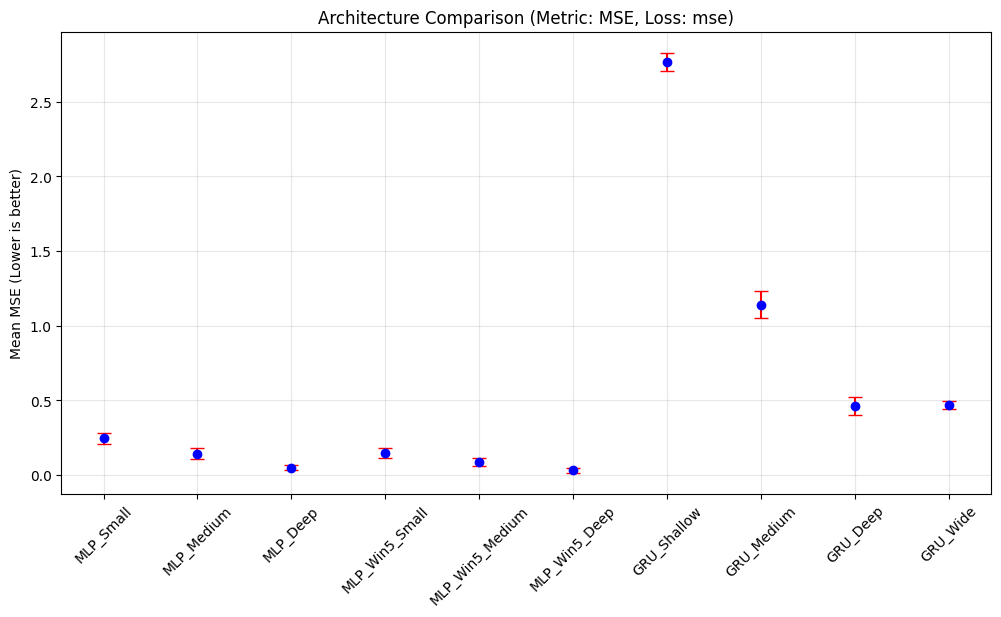


=== PHASE 2 RANKING ===
   Architecture  Mean MSE  Std Dev
  MLP_Win5_Deep  0.031661 0.015227
       MLP_Deep  0.048392 0.015655
MLP_Win5_Medium  0.086433 0.024345
     MLP_Medium  0.143030 0.036537
 MLP_Win5_Small  0.146757 0.031830
      MLP_Small  0.245414 0.038286
       GRU_Deep  0.462677 0.059308
       GRU_Wide  0.467276 0.027069
     GRU_Medium  1.141093 0.088833
    GRU_Shallow  2.765531 0.062507


In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_viz = []
for name, stats in archi_results.items():
    data_viz.append({
        'Architecture': name,
        'Mean MSE': stats['mse_mean'],
        'Std Dev': stats['mse_std']
    })

df = pd.DataFrame(data_viz)

plt.figure(figsize=(12, 6))
# Plot with Error Bars
plt.errorbar(x=df['Architecture'], y=df['Mean MSE'], yerr=df['Std Dev'], fmt='o', capsize=5, ecolor='red', color='blue')
plt.title(f"Architecture Comparison (Metric: MSE, Loss: {BEST_LOSS})")
plt.ylabel("Mean MSE (Lower is better)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

print("\n=== PHASE 2 RANKING ===")
df_sorted = df.sort_values(by='Mean MSE')
print(df_sorted.to_string(index=False))

### With scaling and window size of 5, results are similar to MLP with window size of 1. Temporal context does not seem to help.
### Test: Scaled MLP (without sliding window) - Does increasing width help?

In [11]:
# Train scaled MLP architecture WITHOUT sliding window
# Keep only the truly larger variant (Deep_Scaled) to avoid duplicate configs

scaled_nonwindowed_configs = {
    'MLP_Deep_Scaled': {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [512, 256, 128, 64]}, 'dataset_type': 'mlp', 'window_size': 1},
}

scaled_nonwindowed_results = {}

for name, config in scaled_nonwindowed_configs.items():
    window_size = config.get('window_size', 1) or 1
    stats = run_experiment_repeated(
        model_name=name,
        model_class=config['class'],
        params=config['params'],
        dataset_type=config['dataset_type'],
        loss_type='mse',
        n_runs=5,
        n_epochs=50,
        window_size=window_size
    )
    scaled_nonwindowed_results[name] = stats


>>> EXPERIMENT: MLP_Deep_Scaled | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Deep_Scaled: 100%|██████████| 50/50 [03:10<00:00,  3.82s/it, loss=0.2695, mse=0.2710, mae=0.0752]


Final Test MSE: 0.07127
Done. (MSE: 0.1271)
   Run 2/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Deep_Scaled: 100%|██████████| 50/50 [03:25<00:00,  4.10s/it, loss=0.1258, mse=0.1274, mae=0.1367]


Final Test MSE: 0.03531
Done. (MSE: 0.0247)
   Run 3/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Deep_Scaled: 100%|██████████| 50/50 [03:17<00:00,  3.96s/it, loss=0.2643, mse=0.2677, mae=0.1047]


Final Test MSE: 0.11028
Done. (MSE: 0.0459)
   Run 4/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Deep_Scaled: 100%|██████████| 50/50 [03:36<00:00,  4.34s/it, loss=0.0388, mse=0.0390, mae=0.0777]


Final Test MSE: 0.02223
Done. (MSE: 0.0239)
   Run 5/5... Split sizes: Train=685, Val=86, Test=86 | window_size=1


Training MLP_Deep_Scaled: 100%|██████████| 50/50 [03:33<00:00,  4.26s/it, loss=0.0915, mse=0.0921, mae=0.0862]


Final Test MSE: 0.11246
Done. (MSE: 0.0304)
   >>> MLP_Deep_Scaled Finished. Avg MSE: 0.0504 ± 0.0392


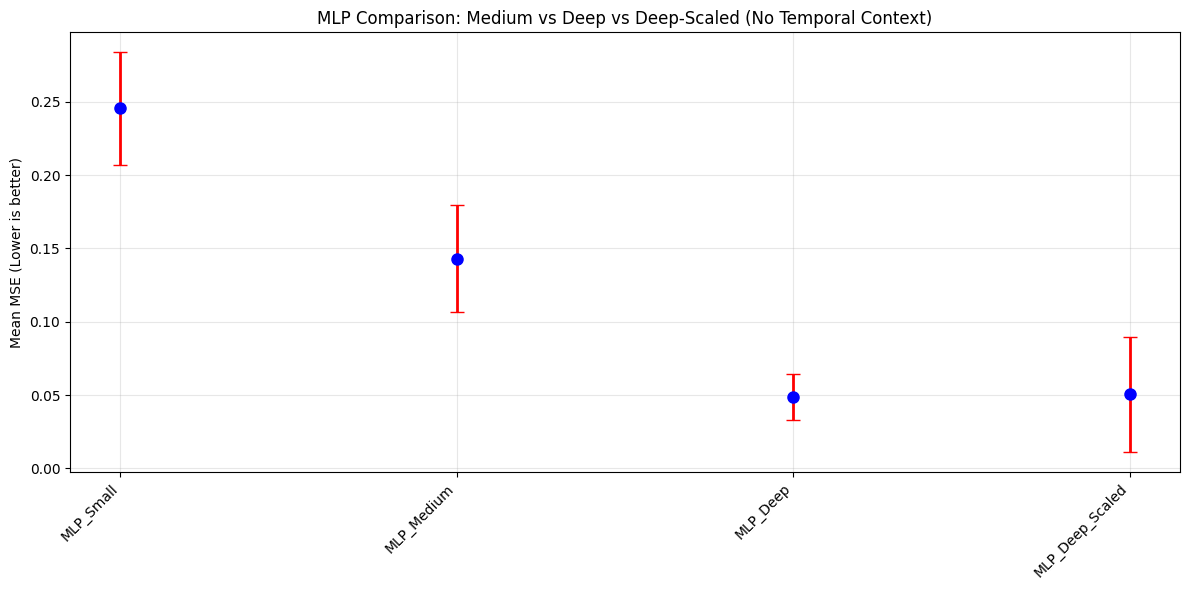


=== COMPARISON RANKING ===
(MLP_Medium vs MLP_Deep vs MLP_Deep_Scaled)
   Architecture  Mean MSE  Std Dev
       MLP_Deep  0.048392 0.015655
MLP_Deep_Scaled  0.050377 0.039159
     MLP_Medium  0.143030 0.036537
      MLP_Small  0.245414 0.038286


In [12]:
# Compare: Original non-windowed vs Deep scaled (no window)

import pandas as pd
import matplotlib.pyplot as plt

comparison_results = {}

# Add selected original non-windowed results
for name in ['MLP_Small', 'MLP_Medium', 'MLP_Deep']:
    if name in archi_results:
        comparison_results[name] = archi_results[name]

# Add deep scaled non-windowed result
if 'MLP_Deep_Scaled' in scaled_nonwindowed_results:
    comparison_results['MLP_Deep_Scaled'] = scaled_nonwindowed_results['MLP_Deep_Scaled']

# Create visualization
data_viz_comparison = []
for name, stats in comparison_results.items():
    data_viz_comparison.append({
        'Architecture': name,
        'Mean MSE': stats['mse_mean'],
        'Std Dev': stats['mse_std']
    })

df_comparison = pd.DataFrame(data_viz_comparison)

plt.figure(figsize=(12, 6))
plt.errorbar(x=df_comparison['Architecture'], y=df_comparison['Mean MSE'], yerr=df_comparison['Std Dev'], 
             fmt='o', capsize=5, ecolor='red', color='blue', markersize=8, linewidth=2)
plt.title("MLP Comparison: Medium vs Deep vs Deep-Scaled (No Temporal Context)")
plt.ylabel("Mean MSE (Lower is better)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n=== COMPARISON RANKING ===")
print("(MLP_Medium vs MLP_Deep vs MLP_Deep_Scaled)")
df_comparison_sorted = df_comparison.sort_values(by='Mean MSE')
print(df_comparison_sorted.to_string(index=False))

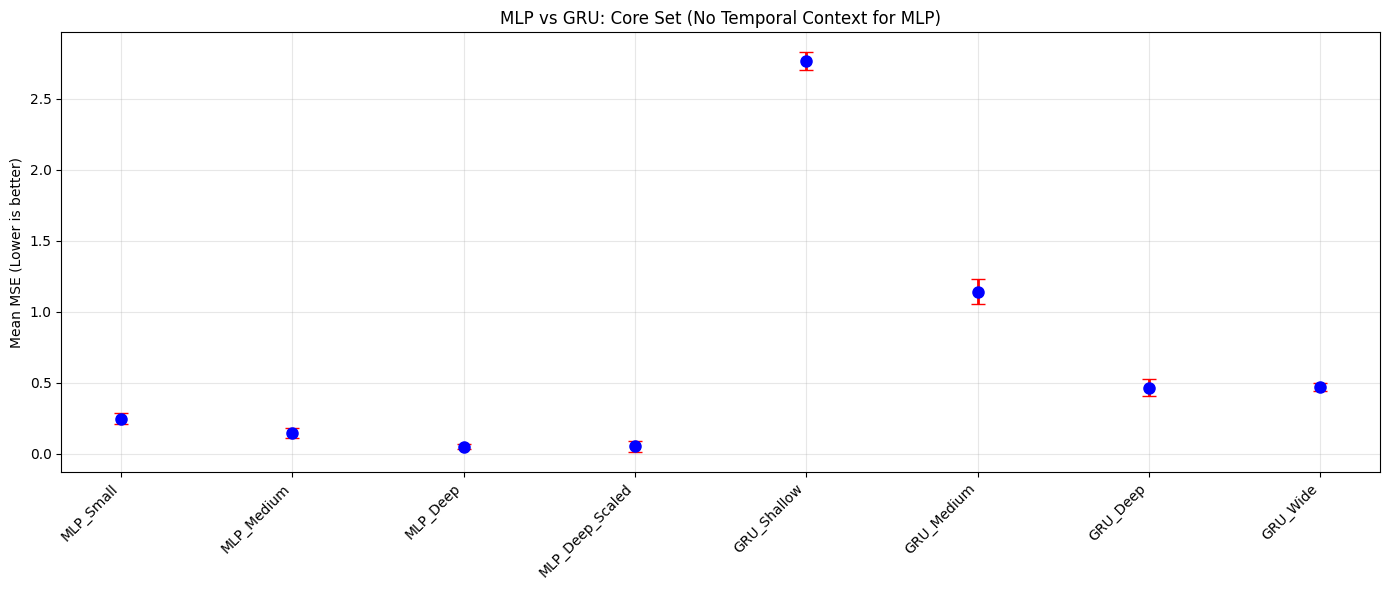


=== FULL COMPARISON RANKING ===
   Architecture  Mean MSE  Std Dev
       MLP_Deep  0.048392 0.015655
MLP_Deep_Scaled  0.050377 0.039159
     MLP_Medium  0.143030 0.036537
      MLP_Small  0.245414 0.038286
       GRU_Deep  0.462677 0.059308
       GRU_Wide  0.467276 0.027069
     GRU_Medium  1.141093 0.088833
    GRU_Shallow  2.765531 0.062507


In [13]:
# Compare: MLP core set + GRUs (includes Deep_Scaled)
# Models: MLP_Small, MLP_Medium, MLP_Deep, MLP_Deep_Scaled, GRU_Shallow/Mediu m/Deep/Wide

import pandas as pd
import matplotlib.pyplot as plt

comparison_results_full = {}

# Add MLP baselines
for name in ['MLP_Small', 'MLP_Medium', 'MLP_Deep']:
    if name in archi_results:
        comparison_results_full[name] = archi_results[name]

# Add MLP deep scaled
if 'MLP_Deep_Scaled' in scaled_nonwindowed_results:
    comparison_results_full['MLP_Deep_Scaled'] = scaled_nonwindowed_results['MLP_Deep_Scaled']

# Add GRU variants
for name in ['GRU_Shallow', 'GRU_Medium', 'GRU_Deep', 'GRU_Wide']:
    if name in archi_results:
        comparison_results_full[name] = archi_results[name]

# Build DataFrame
viz_rows = []
for name, stats in comparison_results_full.items():
    viz_rows.append({
        'Architecture': name,
        'Mean MSE': stats['mse_mean'],
        'Std Dev': stats['mse_std']
    })

df_full = pd.DataFrame(viz_rows)

plt.figure(figsize=(14, 6))
plt.errorbar(x=df_full['Architecture'], y=df_full['Mean MSE'], yerr=df_full['Std Dev'],
             fmt='o', capsize=5, ecolor='red', color='blue', markersize=8, linewidth=2)
plt.title("MLP vs GRU: Core Set (No Temporal Context for MLP)")
plt.ylabel("Mean MSE (Lower is better)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n=== FULL COMPARISON RANKING ===")
df_full_sorted = df_full.sort_values(by='Mean MSE')
print(df_full_sorted.to_string(index=False))

In [14]:
# Train SCALED MLP window-5 architecture (only Deep_Scaled) to test higher capacity with temporal context
WINDOW_SIZE_WIN = 5

window5_scaled_configs = {
    'MLP_Win5_Deep_Scaled': {'class': MLP, 'params': {'input_dim': WINDOW_SIZE_WIN * 6 + 3, 'hidden_dims': [512, 256, 128, 64]}, 'dataset_type': 'mlp', 'window_size': WINDOW_SIZE_WIN},
}

window5_scaled_results = {}

for name, config in window5_scaled_configs.items():
    window_size = config.get('window_size', 1) or 1
    stats = run_experiment_repeated(
        model_name=name,
        model_class=config['class'],
        params=config['params'],
        dataset_type=config['dataset_type'],
        loss_type='mse',
        n_runs=5,
        n_epochs=50,
        window_size=window_size
    )
    window5_scaled_results[name] = stats


>>> EXPERIMENT: MLP_Win5_Deep_Scaled | Loss: mse | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep_Scaled: 100%|██████████| 50/50 [06:14<00:00,  7.49s/it, loss=0.1039, mse=0.1043, mae=0.0733]


Final Test MSE: 0.05134
Done. (MSE: 0.0213)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep_Scaled: 100%|██████████| 50/50 [06:14<00:00,  7.48s/it, loss=0.2117, mse=0.2127, mae=0.0759]


Final Test MSE: 0.02952
Done. (MSE: 0.0450)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep_Scaled: 100%|██████████| 50/50 [06:17<00:00,  7.56s/it, loss=0.0231, mse=0.0232, mae=0.0571]


Final Test MSE: 0.02062
Done. (MSE: 0.0232)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep_Scaled: 100%|██████████| 50/50 [06:22<00:00,  7.65s/it, loss=0.0517, mse=0.0519, mae=0.0765]


Final Test MSE: 0.13006
Done. (MSE: 0.0283)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep_Scaled: 100%|██████████| 50/50 [06:15<00:00,  7.51s/it, loss=0.0559, mse=0.0560, mae=0.0665]


Final Test MSE: 0.02428
Done. (MSE: 0.0486)
   >>> MLP_Win5_Deep_Scaled Finished. Avg MSE: 0.0333 ± 0.0113


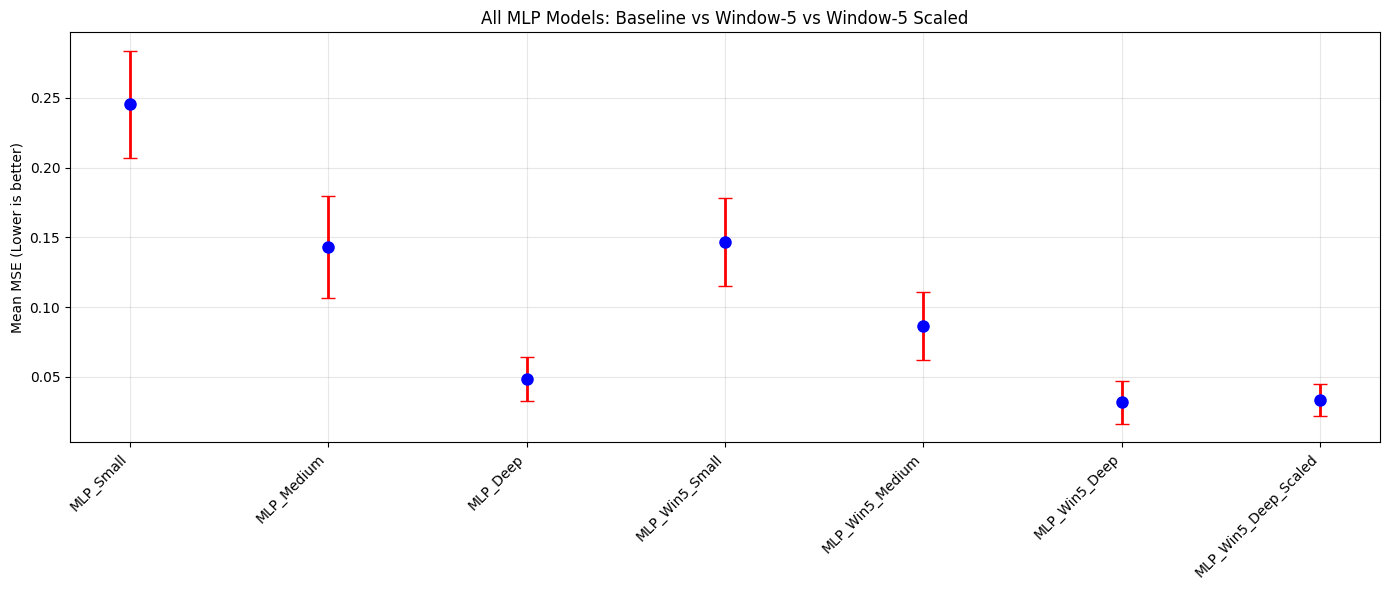


=== WINDOWED SCALING COMPARISON (7 models) ===
        Architecture  Mean MSE  Std Dev
       MLP_Win5_Deep  0.031661 0.015227
MLP_Win5_Deep_Scaled  0.033261 0.011321
            MLP_Deep  0.048392 0.015655
     MLP_Win5_Medium  0.086433 0.024345
          MLP_Medium  0.143030 0.036537
      MLP_Win5_Small  0.146757 0.031830
           MLP_Small  0.245414 0.038286


In [15]:
# Plot comparison: Baseline MLP (win=1), MLP win=5 (unscaled), and MLP win=5 Deep_Scaled

import pandas as pd
import matplotlib.pyplot as plt

comparison_win5_scaled = {}

# Baseline non-windowed
for name in ['MLP_Small', 'MLP_Medium', 'MLP_Deep']:
    if name in archi_results:
        comparison_win5_scaled[name] = archi_results[name]

# Window-5 unscaled (from archi_results)
for name in ['MLP_Win5_Small', 'MLP_Win5_Medium', 'MLP_Win5_Deep']:
    if name in archi_results:
        comparison_win5_scaled[name] = archi_results[name]

# Window-5 deep scaled (from previous cell)
if 'MLP_Win5_Deep_Scaled' in window5_scaled_results:
    comparison_win5_scaled['MLP_Win5_Deep_Scaled'] = window5_scaled_results['MLP_Win5_Deep_Scaled']

viz_rows = []
for name, stats in comparison_win5_scaled.items():
    viz_rows.append({
        'Architecture': name,
        'Mean MSE': stats['mse_mean'],
        'Std Dev': stats['mse_std']
    })

df_win5_scaled = pd.DataFrame(viz_rows)

plt.figure(figsize=(14, 6))
plt.errorbar(
    x=df_win5_scaled['Architecture'],
    y=df_win5_scaled['Mean MSE'],
    yerr=df_win5_scaled['Std Dev'],
    fmt='o', capsize=5, ecolor='red', color='blue', markersize=8, linewidth=2
)
plt.title("All MLP Models: Baseline vs Window-5 vs Window-5 Scaled")
plt.ylabel("Mean MSE (Lower is better)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n=== WINDOWED SCALING COMPARISON (7 models) ===")
df_win5_scaled_sorted = df_win5_scaled.sort_values(by='Mean MSE')
print(df_win5_scaled_sorted.to_string(index=False))

In [16]:
# Reload results from JSON after kernel restart
# Reads results/pytorch_comparison/results/*.json and rebuilds aggregated metrics

import os, glob, json
import numpy as np
import pandas as pd

RESULTS_JSON_DIR = os.path.join(OUTPUT_DIR, "results")

# Expected filename: {model_name}_best_{loss_type}_{trial}_results.json
def parse_filename(fname):
    base = os.path.basename(fname)
    if not base.endswith("_results.json"):
        return None, None, None
    stem = base[:-len("_results.json")]
    if "_best_" not in stem:
        return None, None, None
    model_part, rest = stem.split("_best_", 1)
    parts = rest.split("_")
    if len(parts) < 2:
        return None, None, None
    loss_type = parts[0]
    trial = parts[1]
    return model_part, loss_type, trial

records = []
for path in glob.glob(os.path.join(RESULTS_JSON_DIR, "*_results.json")):
    model_name, loss_type, trial = parse_filename(path)
    if model_name is None:
        continue
    with open(path, "r") as f:
        data = json.load(f)
    metrics = data.get("final_test_results") or data.get("best_results") or {}
    records.append({
        "model_name": model_name,
        "loss_type": loss_type,
        "trial": int(trial) if str(trial).isdigit() else trial,
        "mse": float(metrics.get("mse", np.nan)),
        "mae": float(metrics.get("mae", np.nan)),
        "direction_accuracy": float(metrics.get("direction_accuracy", np.nan)),
        "explained_variance": float(metrics.get("explained_variance", np.nan)),
    })

results_df = pd.DataFrame(records)
aggregated_results = {}

if not results_df.empty:
    grouped = results_df.groupby("model_name")
    for name, g in grouped:
        aggregated_results[name] = {
            "mse_mean": g["mse"].mean(),
            "mse_std": g["mse"].std(ddof=0),
            "mae_mean": g["mae"].mean(),
            "mae_std": g["mae"].std(ddof=0),
            "direction_accuracy_mean": g["direction_accuracy"].mean(),
            "direction_accuracy_std": g["direction_accuracy"].std(ddof=0),
            "explained_variance_mean": g["explained_variance"].mean(),
            "explained_variance_std": g["explained_variance"].std(ddof=0),
        }
else:
    print("No result files found in", RESULTS_JSON_DIR)

# Backward-compatibility for plotting cells (filter subsets if needed)
archi_results = aggregated_results
scaled_nonwindowed_results = {k: v for k, v in aggregated_results.items() if "Deep_Scaled" in k and "Win5" not in k}
window5_scaled_results = {k: v for k, v in aggregated_results.items() if "Win5_Deep_Scaled" in k}

print("Loaded results from", RESULTS_JSON_DIR)
print(f"Total files: {len(records)} | Unique models: {len(aggregated_results)}")
if not results_df.empty:
    print(results_df[["model_name", "trial", "mse", "mae"]]
          .sort_values(["model_name", "trial"]).to_string(index=False))

Loaded results from ../results/pytorch_comparison/results
Total files: 60 | Unique models: 12
          model_name  trial      mse      mae
            GRU_Deep      1 0.569212 0.218063
            GRU_Deep      2 0.397980 0.195991
            GRU_Deep      3 0.503849 0.234727
            GRU_Deep      4 0.460083 0.221356
            GRU_Deep      5 0.547769 0.234199
          GRU_Medium      1 1.140346 0.278113
          GRU_Medium      2 1.030827 0.257322
          GRU_Medium      3 1.099317 0.254987
          GRU_Medium      4 1.129870 0.276519
          GRU_Medium      5 1.081875 0.276627
         GRU_Shallow      1 2.699781 0.408899
         GRU_Shallow      2 2.452011 0.416711
         GRU_Shallow      3 2.357508 0.386454
         GRU_Shallow      4 2.739321 0.416541
         GRU_Shallow      5 2.749919 0.420388
            GRU_Wide      1 0.401682 0.144331
            GRU_Wide      2 0.568185 0.164987
            GRU_Wide      3 0.650578 0.168202
            GRU_Wide      4 0.52

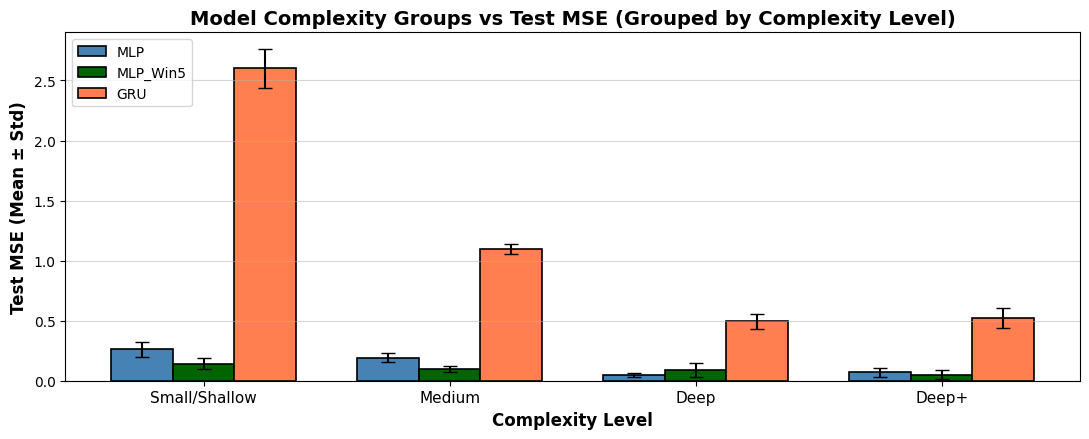


=== MODELS GROUPED BY COMPLEXITY LEVEL ===

SMALL/SHALLOW:
         Model     Type      MSE      Std
     MLP_Small      MLP 0.262058 0.061242
MLP_Win5_Small MLP_Win5 0.142286 0.046144
   GRU_Shallow      GRU 2.599708 0.162816
  Group Average MSE: 1.00135 ± 0.09007

MEDIUM:
          Model     Type      MSE      Std
     MLP_Medium      MLP 0.192234 0.040344
MLP_Win5_Medium MLP_Win5 0.097076 0.023237
     GRU_Medium      GRU 1.096447 0.038912
  Group Average MSE: 0.46192 ± 0.03416

DEEP:
        Model     Type      MSE      Std
     MLP_Deep      MLP 0.047428 0.014806
MLP_Win5_Deep MLP_Win5 0.091949 0.059482
     GRU_Deep      GRU 0.495779 0.061643
  Group Average MSE: 0.21172 ± 0.04531

DEEP+:
               Model     Type      MSE      Std
     MLP_Deep_Scaled      MLP 0.070311 0.037179
MLP_Win5_Deep_Scaled MLP_Win5 0.051165 0.040861
            GRU_Wide      GRU 0.525409 0.083113
  Group Average MSE: 0.21563 ± 0.05372


In [17]:
# Model Complexity vs MSE: Grouped chart showing all 12 models
# Models grouped by complexity level: (Small, Medium, Deep, etc.)
# Colors by model type: MLP (blue), MLP_Win5 (green), GRU (coral)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define complexity groups and assign each model to a group
complexity_groups = {
    'Small/Shallow': ['MLP_Small', 'MLP_Win5_Small', 'GRU_Shallow'],
    'Medium': ['MLP_Medium', 'MLP_Win5_Medium', 'GRU_Medium'],
    'Deep': ['MLP_Deep', 'MLP_Win5_Deep', 'GRU_Deep'],
    'Deep+': ['MLP_Deep_Scaled', 'MLP_Win5_Deep_Scaled', 'GRU_Wide'],
}

# Define colors by model type
type_colors = {
    'MLP': 'steelblue',
    'MLP_Win5': 'darkgreen',
    'GRU': 'coral',
}

def get_model_type(model_name):
    """Extract model type from model name"""
    if 'MLP_Win5' in model_name:
        return 'MLP_Win5'
    elif 'MLP' in model_name:
        return 'MLP'
    elif 'GRU' in model_name:
        return 'GRU'
    return 'Unknown'

# Collect all results
all_results = {}
all_results.update(archi_results)
all_results.update(scaled_nonwindowed_results)
all_results.update(window5_scaled_results)

# Build data for plotting
data_by_group = {group: [] for group in complexity_groups.keys()}
model_info = []

for group, models in complexity_groups.items():
    for model_name in models:
        if model_name in all_results:
            stats = all_results[model_name]
            model_type = get_model_type(model_name)
            data_by_group[group].append({
                'Model': model_name,
                'Type': model_type,
                'MSE': stats['mse_mean'],
                'Std': stats['mse_std'],
            })
            model_info.append({
                'Group': group,
                'Model': model_name,
                'Type': model_type,
                'MSE': stats['mse_mean'],
                'Std': stats['mse_std'],
            })

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(11, 4.5))

# Define bar positions and colors
groups = list(complexity_groups.keys())
x_positions = np.arange(len(groups))
bar_width = 0.25

# Track which types we've added to legend (to avoid duplicates)
legend_added = set()

# For each group, plot its models side by side
group_index = 0
for group in groups:
    models_in_group = data_by_group[group]
    num_models = len(models_in_group)
    
    # Calculate x positions for bars in this group
    group_x_start = group_index - (num_models - 1) * bar_width / 2
    
    for i, model_data in enumerate(models_in_group):
        x_pos = group_x_start + i * bar_width
        model_type = model_data['Type']
        color = type_colors[model_type]
        
        # Add label only once per type
        label = model_type if model_type not in legend_added else ''
        if model_type not in legend_added:
            legend_added.add(model_type)
        
        ax.bar(x_pos, model_data['MSE'], bar_width, 
               yerr=model_data['Std'], label=label,
               capsize=5, edgecolor='black', linewidth=1.2, color=color)
    
    group_index += 1

# Formatting
ax.set_xlabel('Complexity Level', fontsize=12, fontweight='bold')
ax.set_ylabel('Test MSE (Mean ± Std)', fontsize=12, fontweight='bold')
ax.set_title('Model Complexity Groups vs Test MSE (Grouped by Complexity Level)', fontsize=14, fontweight='bold')
ax.set_xticks(np.arange(len(groups)))
ax.set_xticklabels(groups, fontsize=11)
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.5, axis='y')
plt.tight_layout()
plt.show()

# Print summary table
df_summary = pd.DataFrame(model_info)
print("\n=== MODELS GROUPED BY COMPLEXITY LEVEL ===")
for group in groups:
    group_data = df_summary[df_summary['Group'] == group]
    print(f"\n{group.upper()}:")
    print(group_data[['Model', 'Type', 'MSE', 'Std']].to_string(index=False))
    print(f"  Group Average MSE: {group_data['MSE'].mean():.5f} ± {group_data['Std'].mean():.5f}")